In [1]:
import numpy as np
import matplotlib.pylab as plt
from math import exp,log,sqrt,pi,sin
import scipy.stats as sts
import pandas as pd
%matplotlib inline

## Pruebas de Bondad de Ajuste

### Kolgomorov - Smirnov
$D_n=\sup_{-\infty<t<\infty}|F_0(t)-\hat{F}_n(t)|$

In [14]:
def Dn(F0,X):
    n = len(X)
    X.sort()
    Fn = lambda x: ((1/n)*sum([1*(X[i]<=x) for i in range(n)]))
    plt.plot(np.linspace(min(X),max(X)),[F0(z) for z in np.linspace(min(X),max(X))])
    plt.step(X,[Fn(xi) for xi in X])
    return max([max(i/n-F0(X[i]),F0(X[i])-(i-1)/n) for i in range(n)])

In [28]:
X = np.random.normal(0,1,200)

0.06467115723359623

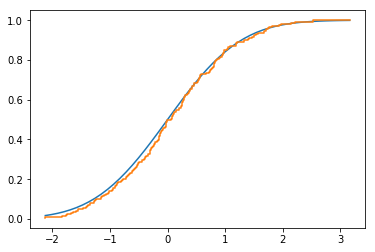

In [29]:
Dn(sts.norm.cdf,X)

### Cramér-von Mises
$C_n=\int(F_0(t)-\hat{F}_n(t))^2dF_0(t)$

In [26]:
def Cn(F0,X):
    n = len(X)
    X.sort()
    Fn = lambda x: ((1/n)*sum([1*(X[i]<=x) for i in range(n)]))
    return 1/(12*n) + sum([(F0(X[i])-(2*i-1)/(2*n))**2 for i in range(n)])

In [27]:
Cn(sts.norm.cdf,X)

29.608896165355517

### Anderson-Darling
$A_n=\int\frac{(\hat{F}_n(t)-F_0(t))^2}{F_0(t)(1-F_0(t))}dF_0(t)$

In [20]:
def An(F0,X):
    n = len(X)
    X.sort()
    Fn = lambda x: ((1/n)*sum([1*(X[i]<=x) for i in range(n)]))
    return -n-(1/n)*(sum([(2*i-1)*(log(F0(X[i]))+log(1-F0(X[n-i-1]))) for i in range(n)]))

In [21]:
An(sts.norm.cdf,X)

-2.368659186433973

In [30]:
def BB(n):
    T = np.linspace(0,1,n)
    n = len(T)
    B = np.ones(n)*0
    for i in range(n):
        xi = sqrt(2)*np.random.randn()/((i+1)*pi)
        B = B + xi* np.array(list(map(lambda x:sin((i+1)*pi*x),T))) 
    return B

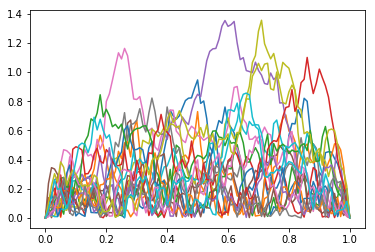

In [31]:
for _ in range(20):
    plt.plot(np.linspace(0,1,101),abs(BB(101)))

In [36]:
sim =[]
for _ in range(500):
    sim.append(max(abs(BB(500))))

In [37]:
S = lambda x =1:1-2*sum([(-1)**(j-1)*exp(-2*(j**2)*(x**2)) for j in range(1,100)])

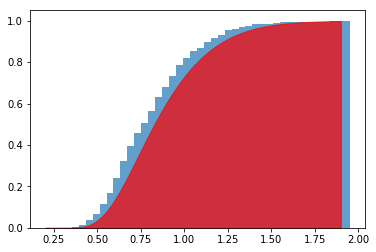

In [38]:
p = plt.hist(sim,bins=40,density=True,cumulative=True,alpha=0.7)
p = plt.fill_between(np.linspace(0.2,1.9,100),[S(x) for x in np.linspace(0.2,1.9,100)],color='red',zorder=2,alpha=0.7)

In [39]:
def KS(X,F,name):
    n = len(X)
    Xi = sorted(X)
    Dn = []
    for i in range(n):
        Dn.append(max((i+1)/n-F(Xi[i]),F(Xi[i])-i/n))
    D = max(Dn)
    K = np.argmax(Dn)
    return D

In [55]:
def BondadDAjuste(X,alpha):
    n=len(X)
    Fn = lambda y:len([x for x in X if x<=y])/n
    m = np.mean(X)
    v = np.var(X)
    inf = min(X)
    sup = max(X)
    a = m*((m*(1-m))/v-1)
    b = a*(1-m)/m
    b_ = m**2/v
    a_ = m/v
    display(pd.DataFrame([m,v,inf,sup,a,b,a_,b_],index=['$\mu$','$\sigma^2$','$\min$',
                                                        '$\max$','$\\alpha$','$\\beta$','$\\mu/\\sigma^{2}$',
                                                        '$\\mu^{2}/\\sigma^{2}$']).T)
    F = {'Normal':lambda x:sts.norm.cdf(x,m,sqrt(v)),
        'Exponencial':lambda x:sts.expon.cdf(x,0,m),
        'Uniforme':lambda x:sts.uniform.cdf(x,inf,sup),
        'Beta':lambda x:sts.beta.cdf(x,a,b),
        'Gamma':lambda x:sts.gamma.cdf(x,a_,0,b_)}
    t = np.arange(inf,sup+0.02,0.01)
    plt.figure(figsize=(16,9))
    Graficas = [plt.plot(t,F[x](t),label=x) for x in F.keys()]
    plt.step(t,list(map(Fn,t)),label='Empirica',lw=2,color='black')
    plt.title('Pruebas de bondad de ajuste')
    plt.legend()
    S =lambda l=1:1-2*sum(((-1)**(j-1))*exp(-2*(j**2)*(l**2)) for j in range(1,300))
    Quant = lambda alpha:max(q for q in np.arange(0.01,4,0.01) if S(q)<alpha)
    KSs = {x:KS(X,F[x],x) for x in F.keys()}
    Calc = {x:[KSs[x],sqrt(n)*KSs[x],Quant(alpha),sqrt(n)*KSs[x]<=Quant(alpha)] for x in F.keys()}
    display(pd.DataFrame(Calc,index=['$D_n$','$\sqrt{n}D_n$','$q_{%s}$'%alpha,'$H_0$']).T)

,$\mu$,$\sigma^2$,$\min$,$\max$,$\alpha$,$\beta$,$\mu/\sigma^{2}$,$\mu^{2}/\sigma^{2}$
0,0.199857,0.025317,0.000311,0.884738,1.062547,4.253989,7.894258,1.577723


,$D_n$,$\sqrt{n}D_n$,$q_{0.15}$,$H_0$
Normal,0.104899,3.3172,0.61,False
Exponencial,0.0779103,2.46374,0.61,False
Uniforme,0.435737,13.7792,0.61,False
Beta,0.0190669,0.602949,0.61,True
Gamma,1,31.6228,0.61,False


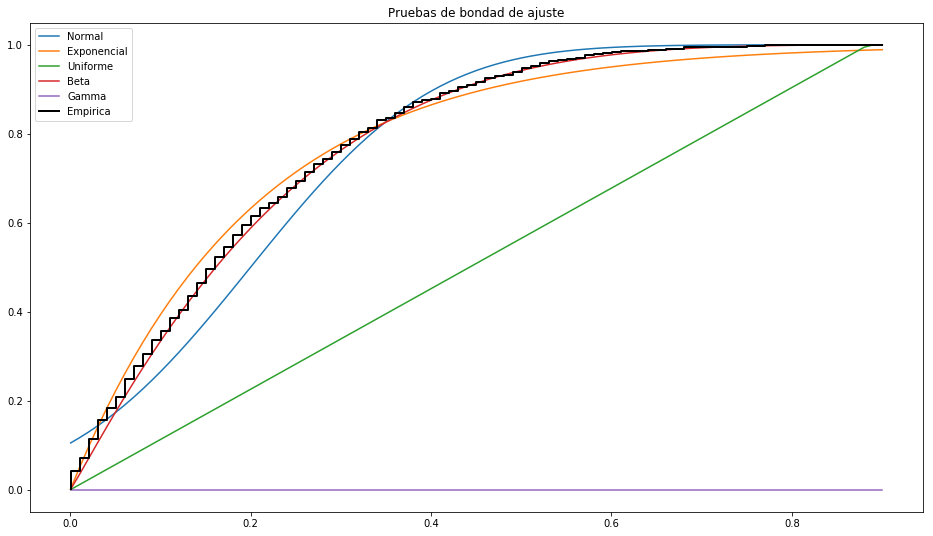

In [59]:
BondadDAjuste(np.random.beta(1,4,1000),0.15)

In [139]:
X = np.random.exponential(2,1000)
Y = np.random.exponential(2,1100)

In [140]:
def Dnm(X,Y,alpha):
    n = len(X)
    m = len(Y)
    X.sort()
    Y.sort()
    Fn = lambda x: ((1/n)*sum([1*(X[i]<=x) for i in range(n)]))
    Gm = lambda x: ((1/m)*sum([1*(Y[i]<=x) for i in range(m)]))
    Z = list(X) + list(Y)
    d = max([abs(Fn(z)-Gm(z)) for z in Z])
    S =lambda l=1:1-2*sum(((-1)**(j-1))*exp(-2*(j**2)*(l**2)) for j in range(1,300))
    Quant = lambda alpha:max(q for q in np.arange(0.01,4,0.01) if S(q)<alpha)
    if sqrt(n*m/(n+m))*d < Quant(alpha):
        print(f'Tu hipotesis es cierta Dnm={sqrt(n*m/(n+m))*d*100:.3f}%, q ={Quant(alpha)*100:.2f}%')
    else:
        print(f'Tu hipotesis se rechaza Dnm={sqrt(n*m/(n+m))*d*100:.3f}%, q ={Quant(alpha)*100:.2f}%')
    p = plt.figure(figsize=(12,6))
    p = plt.step(X,Fn(X),label='Funcion de Distribucion de X')
    p = plt.step(Y,Gm(Y),label='Funcion de Distribucion de Y')
    p = plt.title('$D_{nm}$'+f'={d*100:.3f}%')
    p = plt.legend()

Tu hipotesis se rechaza Dnm=97.373%, q =61.00%


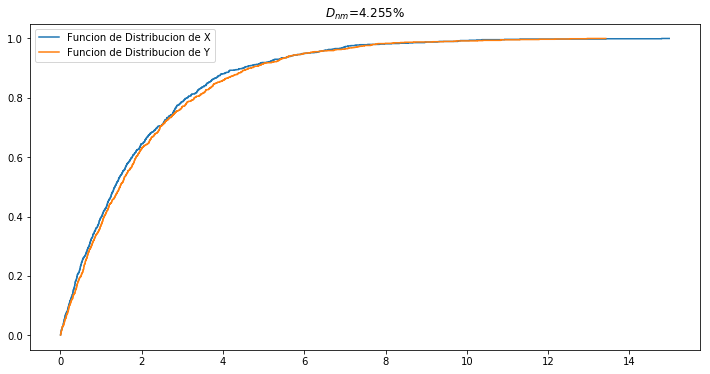

In [142]:
Dnm(X,Y,0.15)

## Grafico Q-Q

In [156]:
X = np.random.normal(0,1,100)
n = len(X)
def Fn(x):
    return((1/n)*sum([1*(X[i]<=x) for i in range(n)]))
def Q(q) :
    return(min([x for x in X if Fn(x)>q]))

In [ ]:
X.sort()
p = plt.figure(figsize=(10,10))
p = plt.plot(X,
        [sts.norm.ppf(i/(n+1)) for i in range(1,n+1)],lw=2,color='black',label='Grafica Q-Q')
p = plt.plot([min(X),max(X)],[min(X),max(X)],color='red',alpha=0.8)
p = plt.legend(loc='upper left')